# Hyperbolic Kuramoto Tree Embedding

This notebook demonstrates how to embed a tree in a hyperbolic disc using a Kuramoto-inspired dynamical system. We begin by introducing the mathematical formulation and then provide the complete Python implementation (using PyTorch and Geoopt) to generate the embedding.

## Overview

1. **Graph and Hyperbolic Embedding**:  We start with a tree (or any graph) and assign each node a random point in the hyperbolic disc (the Poincaré disc). In hyperbolic geometry, hierarchical structures (such as trees) are naturally represented: nodes close to the root lie near the center and nodes deeper in the tree lie near the boundary.

2. **Kuramoto Dynamics in Hyperbolic Space**: The classical Kuramoto model operates on the unit circle. Here, we extend the idea to the hyperbolic disc by representing each node as a complex number $z_i$ with $|z_i| < 1$. The dynamics are given by the differential equation:

$$
\dot{z_i} = -\frac{1}{2N}\left(\sum_{k=1}^{N} K_{ik}\,\overline{z_k}\right) z_i^2 + \omega\,z_i + \frac{1}{2N}\sum_{k=1}^{N} K_{ik}\,z_k,
$$

where:

- *$K_{ik}$**: is the coupling strength between nodes $i$ and $k$ (encoded in a learnable coupling matrix $K$).
- **$\omega$**: is a scalar representing the intrinsic (natural) frequency.
- The first term, with $z_i^2$ and the conjugates $\overline{z_k}$, introduces the nonlinearity required for compatibility with hyperbolic geometry (i.e. invariance under Möbius transformations).

3. **Loss Function**: To train the system, we compare the hyperbolic distances (or a transformed similarity thereof) between the final embeddings $z_i(T)$ with a target similarity computed from the tree's structure. A regularization term is added to penalize points that approach the boundary of the disc.

In the following sections, we provide the complete code that includes:

- Helper functions for hyperbolic distance and loss evaluation (using Geoopt for the Poincaré Ball).
- Tree generation using NetworkX and computation of target distances.
- Hierarchical initialization of node embeddings within the disc.
- The implementation of the Hyperbolic Kuramoto dynamics with Euler integration.
- A training loop to optimize the coupling parameters $K$ and $\omega$ so that the embedding reflects the tree structure.

Finally, we visualize the resulting embedding and the training loss curve.


In [1]:
import os
import math
import random
import numpy as np
import networkx as nx
import networkx.generators.trees as trees
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import geoopt  # pip install geoopt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# --------------------------
# 1. Hyperbolic Helper Functions
# --------------------------
def hyperbolic_g(x):
    """
    A similarity mapping: for hyperbolic distance x,
    returns a value close to 1 for small x and approaching 0 for large x.
    """
    return 2 * torch.exp(-x) / (1 + torch.exp(-x))

# Create a geoopt manifold instance for the Poincaré Ball (c=1.0 corresponds to curvature)
manifold = geoopt.PoincareBall(c=1.0)

def loss_hyperbolic(z, I, lambda_reg=1.0, border_penalty=5.0):
    """
    z: (N x 2) tensor representing points in the Poincaré disc.
    I: (N x N) target similarity matrix (derived from the tree)
    lambda_reg: regularization weight for the border penalty.
    border_penalty: additional penalty for points near the border (>0.9 in norm).
    """
    # Calculate pairwise hyperbolic distances using geoopt.manifold.dist
    D_hyp = manifold.dist(z.unsqueeze(1), z.unsqueeze(0))  # shape (N, N)
    G = hyperbolic_g(D_hyp)
    loss_data = torch.sum((I - G) ** 2)
    
    # Regularization: push points away from the boundary
    norm_sq = torch.sum(z ** 2, dim=1)
    loss_reg = -lambda_reg * torch.sum(torch.log(1 - norm_sq))
    
    # Additional penalty for points too close to the boundary
    border_mask = norm_sq > 0.81  # i.e. |z|^2 > 0.81 --> |z| > 0.9
    if border_mask.any():
        border_loss = border_penalty * torch.sum((norm_sq[border_mask] - 0.81) / (1 - norm_sq[border_mask]))
    else:
        border_loss = 0.0
        
    return loss_data + loss_reg + border_loss

## 2. Tree Generation and Target Distance Computation

We generate a random tree with $N$ nodes using NetworkX and compute the shortest-path distances between each pair of nodes. These distances are then mapped through the similarity function $g(x)=2e^{-x}/(1+e^{-x})$ to produce the target similarity matrix $I$

In [2]:
def generate_tree_and_distances(N, seed=42):
    """
    Generate a random tree with N nodes and compute pairwise shortest path distances.
    Returns:
        G: a NetworkX tree graph.
        target_dists: (N x N) tensor of graph distances.
    """
    G = trees.random_labeled_rooted_tree(N, seed=seed)
    target_dists = np.zeros((N, N))
    for i in range(N):
        lengths = nx.single_source_shortest_path_length(G, i)
        for j in range(N):
            target_dists[i, j] = lengths[j]
    return G, torch.tensor(target_dists, dtype=torch.float32)

N = 50  # Number of nodes
tree, graph_dists = generate_tree_and_distances(N)

# Compute target similarity matrix by applying the hyperbolic_g function
I_target = hyperbolic_g(graph_dists)  # (N x N) tensor with values in (0, 1]

## 3. Initial Embedding: Hierarchical Tree Initialization

Instead of placing nodes randomly, we can initialize embeddings in a way that reflects the tree's hierarchy. In this example, the root is placed near the center and nodes at increasing depth are assigned larger radii.

In [3]:
def hierarchical_tree_init(tree, root=None, radius=0.9):
    """
    Hierarchical initialization of tree nodes in the Poincaré disc.
    Root is placed near the center, deeper nodes farther out.
    """
    N = len(tree)
    if root is None:
        # Choose a central node based on betweenness centrality
        centrality = nx.betweenness_centrality(tree)
        root = max(centrality, key=centrality.get)
    
    distances = nx.single_source_shortest_path_length(tree, root)
    max_depth = max(distances.values())
    node_to_idx = {node: i for i, node in enumerate(tree.nodes())}
    embeddings = torch.zeros((N, 2))
    
    # Place the root near the center
    root_idx = node_to_idx[root]
    embeddings[root_idx] = torch.tensor([0.01, 0.01]) * (torch.rand(2) - 0.5)
    
    for depth in range(1, max_depth + 1):
        layer_nodes = [n for n, d in distances.items() if d == depth]
        layer_radius = radius * (1 - torch.exp(torch.tensor(-depth / max_depth * 3.0))).item()
        
        for i, node in enumerate(layer_nodes):
            idx = node_to_idx[node]
            parents = [p for p in tree.neighbors(node) if distances[p] < depth]
            if not parents:
                parent_pos = torch.zeros(2)
            else:
                parent = parents[0]
                parent_idx = node_to_idx[parent]
                parent_pos = embeddings[parent_idx]
            
            angle = 2 * math.pi * (i / len(layer_nodes) + 0.1 * torch.rand(1).item())
            if torch.norm(parent_pos) > 0.01:
                parent_angle = torch.atan2(parent_pos[1], parent_pos[0]).item()
                angle = 0.7 * parent_angle + 0.3 * angle
            
            x = layer_radius * math.cos(angle)
            y = layer_radius * math.sin(angle)
            embeddings[idx] = torch.tensor([x, y])
    
    norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
    mask = norms >= 0.99
    if mask.any():
        embeddings = torch.where(mask, embeddings / norms * 0.99, embeddings)
    
    return embeddings

z0 = hierarchical_tree_init(tree, radius=0.8)  # shape: (N, 2)


## 4. Hyperbolic Kuramoto Module

We define a PyTorch module that implements the hyperbolic Kuramoto dynamics. The update rule is given by:

$$
\dot{z_i} = -\frac{1}{2N}\left(\sum_{k=1}^{N} K_{ik}\,\overline{z_k}\right) z_i^2 + \omega\,z_i + \frac{1}{2N}\sum_{k=1}^{N} K_{ik}\,z_k,
$$

where $z_i$ is represented as a complex number (constructed from the 2D coordinates), $K_{ik}$ is the coupling matrix, and \$omega$ is a scalar parameter. Euler integration is used for numerical integration.

In [4]:
class HyperbolicKuramoto(nn.Module):
    def __init__(self, N):
        """
        N: number of nodes.
        Learnable parameters:
          - K: (N x N) coupling matrix.
          - omega: scalar natural frequency.
        """
        super(HyperbolicKuramoto, self).__init__()
        self.N = N
        self.K = nn.Parameter(torch.randn(N, N) * 0.1)
        self.omega = nn.Parameter(torch.tensor(0.1))
        
    def forward(self, z, dt, steps):
        """
        z: initial embeddings (N x 2) in R^2
        dt: time step
        steps: number of Euler integration steps
        Returns: final embeddings (N x 2)
        """
        N = self.N
        # Convert 2D points to complex numbers: x + i y
        z_complex = torch.complex(z[:, 0], z[:, 1])
        
        # Convert K to complex
        K_complex = torch.complex(self.K, torch.zeros_like(self.K))
        
        # Euler integration
        for _ in range(steps):
            conj_z = torch.conj(z_complex)
            S = torch.matmul(K_complex, conj_z)  # shape: (N,)
            term1 = - (1 / (2 * N)) * S * (z_complex ** 2)
            term2 = self.omega * z_complex
            T = torch.matmul(K_complex, z_complex)
            term3 = (1 / (2 * N)) * T
            dz = term1 + term2 + term3
            z_complex = z_complex + dt * dz
            
            # Ensure points remain inside the disc
            abs_z = torch.abs(z_complex)
            mask = abs_z >= 0.999
            if mask.any():
                z_complex = torch.where(mask, z_complex / abs_z * 0.999, z_complex)
        
        # Convert back to 2D
        z_final = torch.stack([torch.real(z_complex), torch.imag(z_complex)], dim=1)
        norms = torch.norm(z_final, p=2, dim=1, keepdim=True)
        mask = norms >= 0.999
        if mask.any():
            z_final = torch.where(mask, z_final / norms * 0.999, z_final)
        return z_final


## 5. Training Loop

We set hyperparameters and run the training loop to optimize the learnable parameters $K$ and $\omega$ so that the final embedding’s hyperbolic similarities match the target similarities $I$.

The loss function is defined as:

$$
\mathcal{L} = \sum_{i,j} \left( g(d_{\text{hyp}}(z_i,z_j)) - I_{ij} \right)^2 - \lambda \sum_i \log(1 - |z_i|^2) + \text{BorderPenalty},
$$

where $g(x) = \frac{2e^{-x}}{1 + e^{-x}}$ and an additional border penalty discourages points from approaching the disc boundary.

In [5]:
# Hyperparameters
dt = 0.05           # time step
steps = 100         # integration steps per epoch
max_epochs = 20000  # maximum epochs
target_loss = 0.01  # target loss to stop training
patience = 500      # early stopping patience
lr = 1e-3
lambda_reg = 1.0    # regularization weight
border_penalty = 5.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model and optimizer
model = HyperbolicKuramoto(N).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Use the hierarchical initialization and move to device
z0_fixed = z0.clone().detach().to(device)
I_target = I_target.to(device)

loss_history = []
best_loss = float('inf')
no_improve_count = 0

epoch = 0
while True:
    optimizer.zero_grad()
    z_final = model(z0_fixed, dt, steps)  # final embeddings (N x 2)
    loss = loss_hyperbolic(z_final, I_target, lambda_reg=lambda_reg, border_penalty=border_penalty)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")
    
    # Early stopping / target loss logic
    if loss.item() < target_loss:
        print(f"Target loss reached: {loss.item():.4f} < {target_loss}")
        break
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if no_improve_count >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    if epoch >= max_epochs - 1:
        print(f"Maximum epochs ({max_epochs}) reached")
        break
    
    epoch += 1

print(f"Training completed after {epoch+1} epochs with final loss: {loss.item():.4f}")


Using device: cuda
Epoch 200 - Loss: 200.7134
Epoch 400 - Loss: 176.3609
Epoch 600 - Loss: 158.5757
Epoch 800 - Loss: 145.3338
Epoch 1000 - Loss: 136.5583
Epoch 1200 - Loss: 130.3863
Epoch 1400 - Loss: 125.5114
Epoch 1600 - Loss: 122.4026
Epoch 1800 - Loss: 119.9468
Epoch 2000 - Loss: 118.3113
Epoch 2200 - Loss: 117.0381
Epoch 2400 - Loss: 115.9209
Epoch 2600 - Loss: 114.9078
Epoch 2800 - Loss: 113.9675
Epoch 3000 - Loss: 113.0977
Epoch 3200 - Loss: 112.3499
Epoch 3400 - Loss: 111.6875
Epoch 3600 - Loss: 111.0440
Epoch 3800 - Loss: 110.4096
Epoch 4000 - Loss: 109.7857
Epoch 4200 - Loss: 109.2033
Epoch 4400 - Loss: 108.5386
Epoch 4600 - Loss: 108.1376
Epoch 4800 - Loss: 107.7968
Epoch 5000 - Loss: 107.5672
Epoch 5200 - Loss: 107.3600
Epoch 5400 - Loss: 107.1011
Epoch 5600 - Loss: 106.3980
Epoch 5800 - Loss: 106.1156
Epoch 6000 - Loss: 105.8607
Epoch 6200 - Loss: 105.5731
Epoch 6400 - Loss: 105.2352
Epoch 6600 - Loss: 104.8665
Epoch 6800 - Loss: 104.4939
Epoch 7000 - Loss: 104.0776
Epoch

## 6. Visualization

We now visualize the final hyperbolic embedding on the Poincaré disc and the training loss curve. Additionally, we display the original tree structure (using a layout from NetworkX) for comparison.

The embedding plot shows nodes as blue points within the disc. We also draw geodesic curves between connected nodes (using geoopt's geodesic functions) when possible.


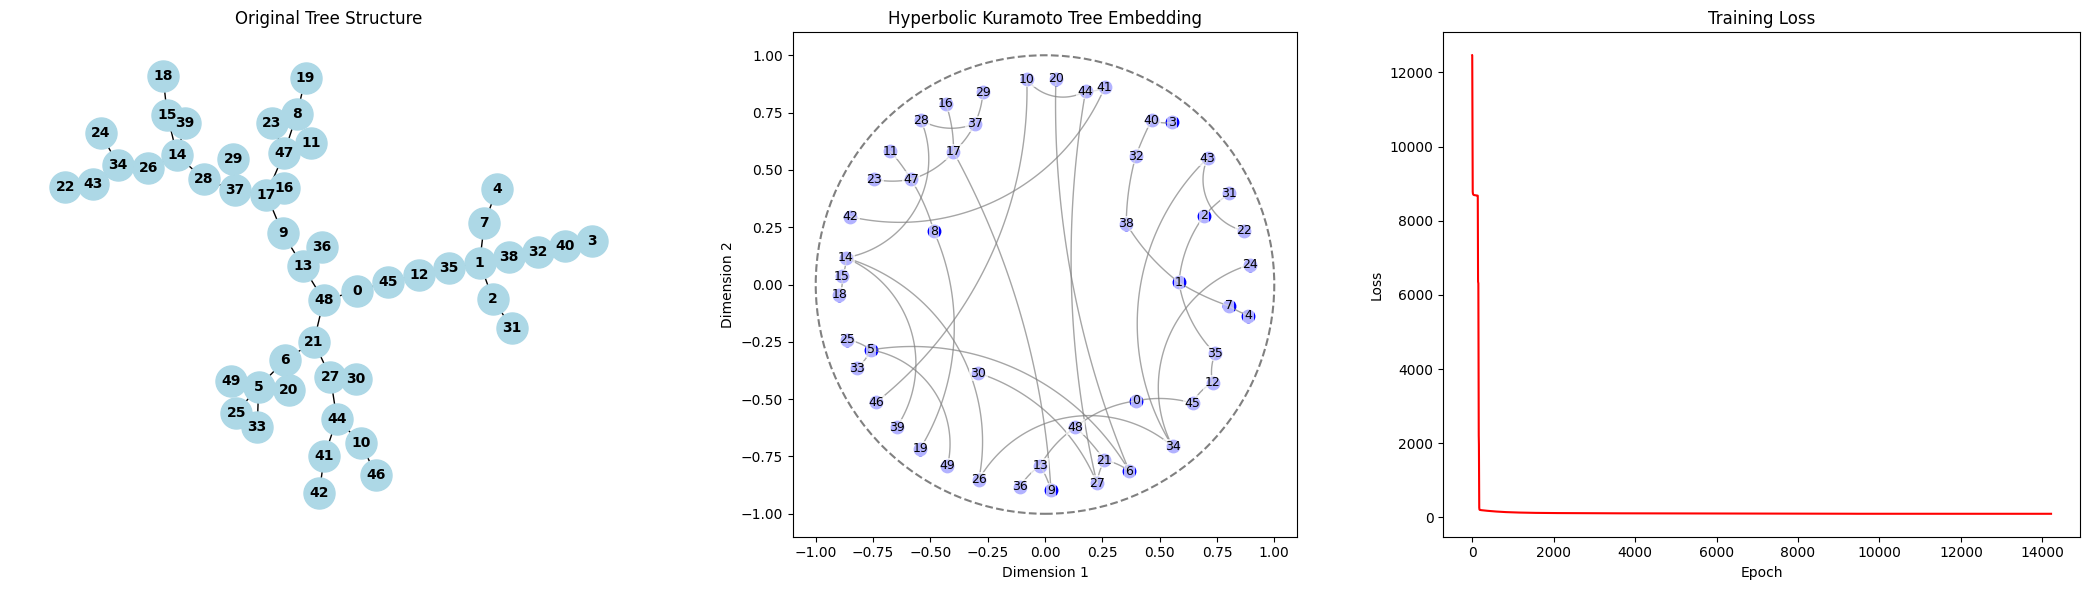

In [7]:
# Convert final embeddings to numpy for plotting
z_final_np = z_final.detach().cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(21, 6))

# (a) Plot original tree structure
pos = nx.kamada_kawai_layout(tree)
nx.draw(tree, pos, ax=ax[0], with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
ax[0].set_title("Original Tree Structure")

# (b) Plot hyperbolic embedding on the Poincaré disc
ax[1].set_aspect("equal")
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1.5)
ax[1].add_artist(circle)
ax[1].scatter(z_final_np[:, 0], z_final_np[:, 1], color='blue', s=80)

# Draw geodesics for each edge in the tree
for edge in tree.edges():
    i, j = edge
    p1 = z_final_np[i]
    p2 = z_final_np[j]
    
    # Convert to tensors
    p1_tensor = torch.tensor(p1, dtype=torch.float32)
    p2_tensor = torch.tensor(p2, dtype=torch.float32)
    
    # Compute a geodesic using geoopt's functionality if possible
    num_points = 150 if (torch.sum(p1_tensor**2) > 0.9 or torch.sum(p2_tensor**2) > 0.9) else 100
    t = torch.linspace(0, 1, num_points)[:, None]
    try:
        geodesic_points = manifold.geodesic(t, p1_tensor, p2_tensor)
        geodesic_points = geodesic_points.detach().cpu().numpy()
        ax[1].plot(geodesic_points[:, 0], geodesic_points[:, 1], color='gray', linewidth=1.0, alpha=0.7, zorder=1)
    except Exception as e:
        ax[1].plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', linestyle='--', linewidth=0.5, alpha=0.5)

for i in range(N):
    ax[1].text(z_final_np[i, 0], z_final_np[i, 1], str(i), fontsize=9, ha='center', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
ax[1].set_title("Hyperbolic Kuramoto Tree Embedding")
ax[1].set_xlabel("Dimension 1")
ax[1].set_ylabel("Dimension 2")
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])

# (c) Loss curve
ax[2].plot(loss_history, color='red')
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")
ax[2].set_title("Training Loss")

plt.tight_layout()
plt.show()


## 7. Conclusion

In this notebook we:

- Described the mathematical formulation of a Kuramoto-based dynamical system extended to hyperbolic space for graph embedding.
- Generated a random tree and computed target similarities based on shortest-path distances.
- Initialized node embeddings in the Poincaré disc using a hierarchical method.
- Implemented the hyperbolic Kuramoto update via Euler integration, ensuring that the embeddings remain within the disc.
- Defined a loss function to match the induced hyperbolic similarities to the target structure and added regularization to avoid the boundary.
- Trained the model and visualized both the final embedding and the loss convergence.

This approach leverages both the dynamic synchronization properties of Kuramoto models and the natural representation of hierarchies in hyperbolic geometry. It is especially well suited for embedding trees or graphs with hierarchical structures.